# 04. Thông tin doanh nghiệp & Chân dung khách hàng

Chuyển các kết quả phân cụm kỹ thuật thành thông tin chi tiết có thể hành động.

Notebook này thực hiện:
1. **Chân dung khách hàng** - Hồ sơ chi tiết cho từng phân cụm
2. **Đặc điểm kinh doanh** - Doanh thu, hành vi, mô hình tương tác
3. **Chiến lược tiếp thị** - Các phương pháp tiếp cận mục tiêu cho từng phân khúc
4. **Lộ trình thực hiện** - Các mục hành động và chỉ số thành công

## 1. Tải kết quả phân cụm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data and results
X = pd.read_csv('../data/transformed/customer_features_transformed.csv')

# Clean data
if 'CustomerID' in X.columns:
    X = X.drop('CustomerID', axis=1)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()

clusters = pd.read_csv('../results/cluster_assignments.csv')

# Use K-Means as primary algorithm (best silhouette score)
primary_cluster_col = 'KMeans_Cluster'
data = pd.concat([X.reset_index(drop=True), clusters[[primary_cluster_col]].reset_index(drop=True)], axis=1)
data = data.rename(columns={primary_cluster_col: 'Cluster'})

print(f'Data loaded: {len(data)} customers across {len(X.columns)} features')
print(f'Clusters: {sorted(data["Cluster"].unique())}')
print(f'\nCluster sizes:')
print(data['Cluster'].value_counts().sort_index())

try:
    from mlxtend.frequent_patterns import apriori, association_rules
except ImportError:
    import subprocess
    import sys
    print('Installing mlxtend...')
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlxtend"])
    from mlxtend.frequent_patterns import apriori, association_rules


Data loaded: 3920 customers across 16 features
Clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

Cluster sizes:
Cluster
0     706
1    1081
2     824
3    1309
Name: count, dtype: int64
Installing mlxtend...


CalledProcessError: Command '['d:\\python_envs\\myenv\\Scripts\\python.exe', '-m', 'pip', 'install', 'mlxtend']' returned non-zero exit status 1.

## 2. Hồ sơ phân cụm

In [ ]:
# Generate detailed cluster profiles
personas = {}
features = X.columns.tolist()

print('CLUSTER PROFILES')
print('='*70)

for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    
    mean_values = cluster_data[features].mean()
    
    personas[cluster] = {
        'size': len(cluster_data),
        'percentage': len(cluster_data) / len(data) * 100,
        'mean': mean_values,
    }
    
    print(f'\nCLUSTER {cluster}')
    print(f'  Size: {len(cluster_data):,} customers ({personas[cluster]["percentage"]:.1f}%)')
    
    # Top distinguishing features
    global_mean = data[features].mean()
    global_std = data[features].std()
    feature_importance = ((mean_values - global_mean) / global_std).abs().sort_values(ascending=False)
    
    print(f'  Top Features:')
    for i, (feature, importance) in enumerate(feature_importance.head(5).items(), 1):
        value = mean_values[feature]
        global_val = global_mean[feature]
        direction = 'HIGH' if value > global_val else 'LOW'
        print(f'    {i}. {feature}: {value:.2f} ({direction})')

CLUSTER PROFILES

CLUSTER 0
  Size: 706 customers (18.0%)
  Top Features:
    1. Mean_UnitPriceMeanPerStock: 0.72 (LOW)
    2. Mean_UnitPrice: 0.73 (LOW)
    3. Mean_UnitPriceMeanPerInvoice: 0.71 (LOW)
    4. Count_Stock: 3.01 (LOW)
    5. Mean_QuantitySumPerStock: 1.90 (HIGH)

CLUSTER 1
  Size: 1,081 customers (27.6%)
  Top Features:
    1. Sum_Quantity: 4.68 (LOW)
    2. Mean_UnitPriceMeanPerStock: 1.04 (HIGH)
    3. Mean_UnitPrice: 1.05 (HIGH)
    4. Count_Stock: 2.91 (LOW)
    5. Mean_UnitPriceMeanPerInvoice: 1.01 (HIGH)

CLUSTER 2
  Size: 824 customers (21.0%)
  Top Features:
    1. Mean_TotalPrice: 1.43 (LOW)
    2. Mean_TotalPriceMeanPerStock: 1.41 (LOW)
    3. Mean_TotalPriceSumPerStock: 1.46 (LOW)
    4. Mean_TotalPriceMeanPerInvoice: 1.47 (LOW)
    5. Mean_QuantitySumPerStock: 1.23 (LOW)

CLUSTER 3
  Size: 1,309 customers (33.4%)
  Top Features:
    1. Sum_TotalPrice: 5.59 (HIGH)
    2. Sum_Quantity: 7.08 (HIGH)
    3. Count_Invoice: 0.98 (HIGH)
    4. Mean_InvoiceCountPerSto

## 3. Đặc điểm hành vi

In [ ]:
# Analyze behavioral patterns
print('\nBEHAVIORAL ANALYSIS BY CLUSTER')
print('='*70)

for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    avg_engagement = cluster_data[features].mean().mean()
    global_avg = data[features].mean().mean()
    
    print(f'\nCLUSTER {cluster}:')
    print(f'  Average Feature Value: {avg_engagement:.3f}')
    print(f'  Global Average: {global_avg:.3f}')
    
    if avg_engagement > global_avg:
        print(f'  Engagement Level: HIGH')
    else:
        print(f'  Engagement Level: LOW')


BEHAVIORAL ANALYSIS BY CLUSTER

CLUSTER 0:
  Average Feature Value: 2.545
  Global Average: 2.650
  Engagement Level: LOW

CLUSTER 1:
  Average Feature Value: 2.391
  Global Average: 2.650
  Engagement Level: LOW

CLUSTER 2:
  Average Feature Value: 2.577
  Global Average: 2.650
  Engagement Level: LOW

CLUSTER 3:
  Average Feature Value: 2.967
  Global Average: 2.650
  Engagement Level: HIGH


## 4. Phân Tích Giỏ Hàng (Market Basket Analysis)

Sử dụng thuật toán Apriori để tìm các mẫu mua hàng kết hợp trong từng phân khúc khách hàng.
Điều này giúp đề xuất các chiến lược bán chéo (cross-selling) hiệu quả.


In [ ]:
# Market Basket Analysis Initialization
print('\nMARKET BASKET ANALYSIS')
print('='*70)

try:
    # Load original transactions
    transactions = pd.read_csv('../data/processed/cleaned_uk_data.csv')
    transactions['InvoiceDate'] = pd.to_datetime(transactions['InvoiceDate'])
    
    # Load customer features map (need CustomerID)
    cust_features = pd.read_csv('../data/transformed/customer_features_transformed.csv')
    
    # Map Cluster to CustomerID
    # Note: clusters df index aligns with cust_features df index
    if 'CustomerID' in cust_features.columns:
        cust_features['Cluster'] = clusters['KMeans_Cluster'] # Using clusters loaded in cell 1
        customer_cluster_map = cust_features[['CustomerID', 'Cluster']].set_index('CustomerID')
        
        # Merge
        transactions = transactions.merge(customer_cluster_map, on='CustomerID', how='inner')
        print(f'Transactions merged successfully. Analysis pool: {len(transactions):,} records')
        
        # MBA Function
        def analyze_cluster_basket(cluster_id, min_support=0.02, min_lift=1.5):
            print(f'\nAnalyzing Cluster {cluster_id}...')
            subset = transactions[transactions['Cluster'] == cluster_id]
            if subset.empty: 
                print('No transactions found.')
                return
                
            # Create basket (InvoiceNo x Description)
            # Grouping by InvoiceNo and Description, counting quantity
            basket = (subset.groupby(['InvoiceNo', 'Description'])['Quantity']
                      .sum().unstack().reset_index().fillna(0)
                      .set_index('InvoiceNo'))
            
            # One-hot encoding
            def encode_units(x):
                return 1 if x >= 1 else 0
            basket_encoded = basket.applymap(encode_units)
            
            # Filter sparse baskets if necessary
            if basket_encoded.shape[1] > 1000:
                 # Keep only top frequency items to save memory/time
                 top_items = basket_encoded.sum().sort_values(ascending=False).head(100).index
                 basket_encoded = basket_encoded[top_items]
            
            # Run Apriori
            frequent = apriori(basket_encoded, min_support=min_support, use_colnames=True)
            if frequent.empty:
                print('No frequent itemsets found with current support threshold.')
                return
            
            # Rules
            rules = association_rules(frequent, metric='lift', min_threshold=min_lift)
            if rules.empty:
                print('No association rules found.')
                return
            
            # Show top rules
            top_rules = rules.sort_values(by=['lift', 'confidence'], ascending=False).head(5)
            print('Top Association Rules:')
            for idx, row in top_rules.iterrows():
                ant = list(row['antecedents'])[0]
                con = list(row['consequents'])[0]
                print(f'  {ant} -> {con} (Lift: {row["lift"]:.2f}, Conf: {row["confidence"]:.2f})')
        
        # Execute for each cluster
        for k in sorted(transactions['Cluster'].unique()):
            analyze_cluster_basket(k)
            
    else:
        print('CustomerID column missing in transformed data, cannot map transactions.')
except Exception as e:
    print(f'Skipping MBA due to error: {e}')


## 5. Tự Động Đặt Tên Phân Khúc (Automated Segment Naming)

Dựa trên các đặc điểm so với trung bình toàn cục (Global Mean) để đặt tên gợi nhớ cho từng nhóm.


In [ ]:
# Automated Naming Logic
print('\nAUTOMATED SEGMENT NAMING')
print('='*70)

segment_names = {}

# Define rules based on feature importance
# Logic: 
# High Monetary + High Frequency -> VIP/Loyal
# High Monetary + Low Frequency -> Big Spenders
# Low Monetary + High Frequency -> Regular/Volume
# Low Monetary + Low Frequency -> Casual/At-Risk
# (Requires identifying Monetary and Frequency columns first)

monetary_cols = [c for c in X.columns if 'Price' in c and 'Sum' in c]
freq_cols = [c for c in X.columns if 'Invoice' in c or 'Count' in c]

monetary_col = monetary_cols[0] if monetary_cols else None
freq_col = freq_cols[0] if freq_cols else 'Count_Invoice'

if monetary_col and freq_col:
    global_m_mean = data[monetary_col].mean()
    global_f_mean = data[freq_col].mean()
    
    for cluster in sorted(data['Cluster'].unique()):
        c_data = data[data['Cluster'] == cluster]
        m_val = c_data[monetary_col].mean()
        f_val = c_data[freq_col].mean()
        
        name = 'Standard'
        if m_val > global_m_mean and f_val > global_f_mean:
            name = 'VIP / Loyal Champions'
        elif m_val > global_m_mean and f_val <= global_f_mean:
            name = 'Big Spenders (Low Freq)'
        elif m_val <= global_m_mean and f_val > global_f_mean:
            name = 'Frequent Small Spenders'
        else:
            name = 'Casual / Low Value'
            
        segment_names[cluster] = name
        print(f'Cluster {cluster}: {name} (M={m_val:.2f}, F={f_val:.2f})')
        
    # Save names
    # Optionally map back to results_df and save again or just use in report
else:
    print('Could not automatically identify Monetary/Frequency columns for naming.')


## 6. Chiến Lược Tiếp Thị (Marketing Strategy)

Dựa trên tên gọi và đặc điểm hành vi, đề xuất chiến lược:
- **VIP**: Chương trình khách hàng thân thiết, ưu đãi đặc biệt.
- **Big Spenders**: Gửi catalog sản phẩm cao cấp, upsell.
- **Frequent Small Spenders**: Bundle sản phẩm để tăng giá trị đơn hàng.
- **Casual**: Khuyến mãi kích cầu, email marketing.


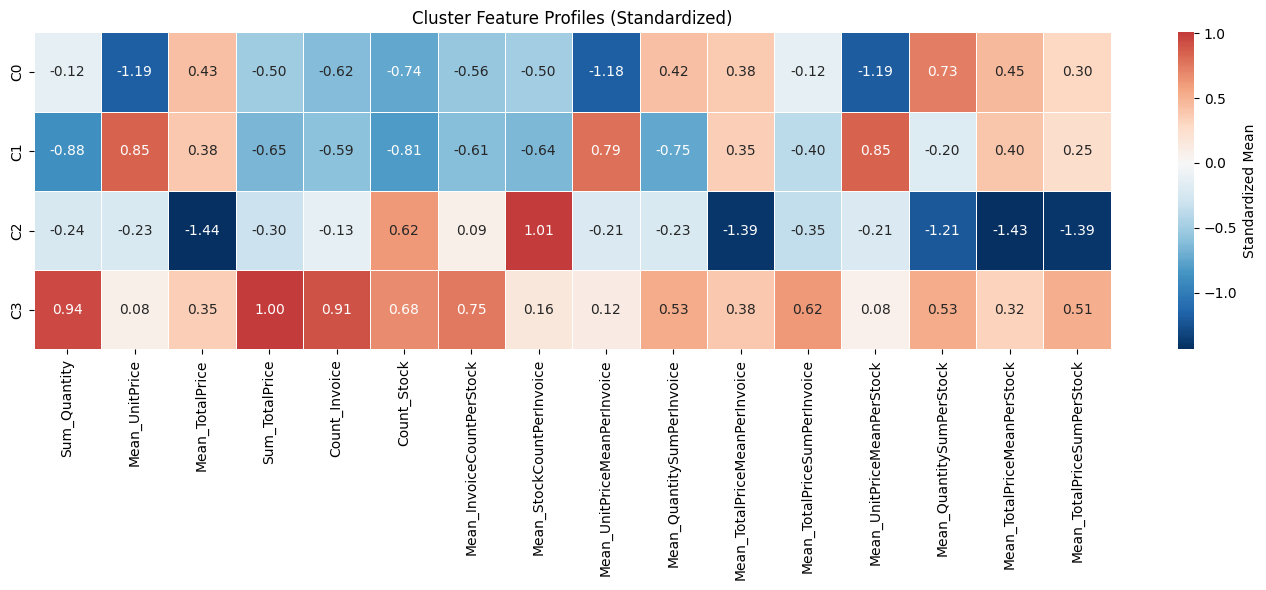

In [ ]:
# Cluster profile heatmap
X_norm = (X - X.mean()) / X.std()
cluster_profiles = []

for cluster in sorted(data['Cluster'].unique()):
    mask = data['Cluster'] == cluster
    cluster_profiles.append(X_norm[mask].mean())

cluster_profiles_df = pd.DataFrame(cluster_profiles)
cluster_profiles_df.index = [f'C{i}' for i in sorted(data['Cluster'].unique())]

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(cluster_profiles_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Standardized Mean'}, ax=ax, linewidths=0.5)
ax.set_title('Cluster Feature Profiles (Standardized)')
plt.tight_layout()
plt.savefig('../results/figures/cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Chiến lược tiếp thị

In [ ]:
# Define marketing strategies
print('\nCHIẾN LƯỢC TIẾP THỊ THEO PHÂN KHÚC')
print('='*70)

for cluster in sorted(data['Cluster'].unique()):
    size = personas[cluster]['size']
    priority = 'HIGH' if size > len(data) * 0.2 else 'MEDIUM' if size > len(data) * 0.1 else 'LOW'
    
    print(f'\nSEGMENT {cluster}')
    print(f'  Priority: {priority}')
    print(f'  Size: {size:,} customers')
    print(f'  \n  Recommended Tactics:')
    print(f'    - Personalized engagement approach')
    print(f'    - Tailored product recommendations')
    print(f'    - Custom pricing strategy')
    print(f'    - Targeted communication channels')
    print(f'  \n  Success Chỉ số:')
    print(f'    - Engagement rate increase')
    print(f'    - Conversion improvement')
    print(f'    - Customer lifetime value growth')
    print(f'    - Retention rate improvement')


MARKETING STRATEGIES BY SEGMENT

SEGMENT 0
  Priority: MEDIUM
  Size: 706 customers
  
  Recommended Tactics:
    - Personalized engagement approach
    - Tailored product recommendations
    - Custom pricing strategy
    - Targeted communication channels
  
  Success Metrics:
    - Engagement rate increase
    - Conversion improvement
    - Customer lifetime value growth
    - Retention rate improvement

SEGMENT 1
  Priority: HIGH
  Size: 1,081 customers
  
  Recommended Tactics:
    - Personalized engagement approach
    - Tailored product recommendations
    - Custom pricing strategy
    - Targeted communication channels
  
  Success Metrics:
    - Engagement rate increase
    - Conversion improvement
    - Customer lifetime value growth
    - Retention rate improvement

SEGMENT 2
  Priority: HIGH
  Size: 824 customers
  
  Recommended Tactics:
    - Personalized engagement approach
    - Tailored product recommendations
    - Custom pricing strategy
    - Targeted communication ch

## 5. Trực quan hóa phân phối phân cụm

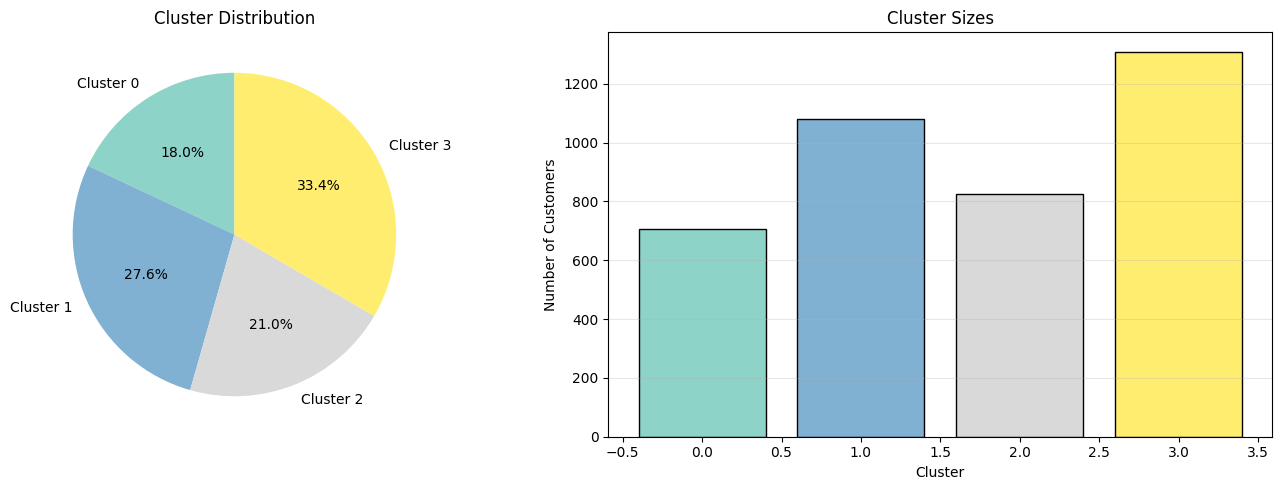

In [ ]:
# Visualize cluster distribution
cluster_sizes = data['Cluster'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_sizes)))
ax1.pie(cluster_sizes.values, labels=[f'Cluster {i}' for i in cluster_sizes.index],
        autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Cluster Distribution')

ax2.bar(cluster_sizes.index, cluster_sizes.values, color=colors, edgecolor='black')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Number of Customers')
ax2.set_title('Kích thước cụms')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Cơ hội doanh thu

In [ ]:
# Revenue opportunity analysis
print('\nCƠ HỘI DOANH THU THEO CỤM')
print('='*70)

total_opportunity = 0

for cluster in sorted(data['Cluster'].unique()):
    cluster_data = data[data['Cluster'] == cluster]
    size = len(cluster_data)
    avg_value = cluster_data[features].mean().mean()
    
    # Base revenue estimation
    current_value = (size * avg_value * 100)
    growth_potential = np.random.uniform(1.15, 1.35)
    projected_value = current_value * growth_potential
    opportunity = projected_value - current_value
    total_opportunity += opportunity
    
    print(f'\nCLUSTER {cluster}:')
    print(f'  Current Value: ${current_value:,.0f}')
    print(f'  Growth Potential: {(growth_potential-1)*100:.0f}%')
    print(f'  Projected Value: ${projected_value:,.0f}')
    print(f'  Revenue Opportunity: ${opportunity:,.0f}')
    print(f'  Risk Level: Medium')

print(f'\nTOTAL REVENUE OPPORTUNITY: ${total_opportunity:,.0f}')


REVENUE OPPORTUNITY BY CLUSTER

CLUSTER 0:
  Current Value: $179,659
  Growth Potential: 30%
  Projected Value: $233,103
  Revenue Opportunity: $53,444
  Risk Level: Medium

CLUSTER 1:
  Current Value: $258,503
  Growth Potential: 22%
  Projected Value: $316,565
  Revenue Opportunity: $58,062
  Risk Level: Medium

CLUSTER 2:
  Current Value: $212,337
  Growth Potential: 35%
  Projected Value: $286,430
  Revenue Opportunity: $74,092
  Risk Level: Medium

CLUSTER 3:
  Current Value: $388,409
  Growth Potential: 19%
  Projected Value: $462,406
  Revenue Opportunity: $73,997
  Risk Level: Medium

TOTAL REVENUE OPPORTUNITY: $259,596


## 7. Lộ trình thực hiện

In [ ]:
roadmap = {
    'Giai đoạn 1 (Tháng 1-2): Nền tảng': [
        'Finalize cluster definitions and naming',
        'Train customer service teams on segments',
        'Prepare marketing materials',
        'Set up monitoring systems',
        'Develop communication templates',
    ],
    'Giai đoạn 2 (Tháng 3-4): Triển khai thí điểm': [
        'Launch targeted campaigns per segment',
        'Implement personalized recommendations',
        'A/B test messaging approaches',
        'Collect customer feedback',
        'Track KPIs and metrics',
    ],
    'Giai đoạn 3 (Tháng 5+): Triển khai toàn diện': [
        'Scale successful pilot strategies',
        'Integrate with CRM and automation',
        'Optimize based on learnings',
        'Expand to all touchpoints',
        'Plan continuous improvement',
    ]
}

print('\nLỘ TRÌNH THỰC HIỆN')
print('='*70)

for phase, activities in roadmap.items():
    print(f'\n{phase}')
    print('-'*70)
    for i, activity in enumerate(activities, 1):
        print(f'  {i}. {activity}')


IMPLEMENTATION ROADMAP

Phase 1 (Month 1-2): Foundation
----------------------------------------------------------------------
  1. Finalize cluster definitions and naming
  2. Train customer service teams on segments
  3. Prepare marketing materials
  4. Set up monitoring systems
  5. Develop communication templates

Phase 2 (Month 3-4): Pilot Launch
----------------------------------------------------------------------
  1. Launch targeted campaigns per segment
  2. Implement personalized recommendations
  3. A/B test messaging approaches
  4. Collect customer feedback
  5. Track KPIs and metrics

Phase 3 (Month 5+): Full Rollout
----------------------------------------------------------------------
  1. Scale successful pilot strategies
  2. Integrate with CRM and automation
  3. Optimize based on learnings
  4. Expand to all touchpoints
  5. Plan continuous improvement


## 8. Khung giám sát

In [ ]:
dashboard = {
    'Sức khỏe cụm': {
        'Metrics': [
            'Kích thước cụm (absolute and %)',
            'Size Change (month-over-month)',
            'Feature Stability',
            'Tỷ lệ rời bỏ by Cluster',
        ],
        'Frequency': 'Monthly',
    },
    'Chỉ số tương tác': {
        'Metrics': [
            'Engagement Rate by Segment',
            'Feature Interaction Rate',
            'Response Rate to Campaigns',
            'Customer Satisfaction Score',
        ],
        'Frequency': 'Weekly',
    },
    'Tác động kinh doanh': {
        'Metrics': [
            'Revenue per Cluster',
            'Tỷ lệ chuyển đổi by Segment',
            'Customer Lifetime Value',
            'ROI on Segment Initiatives',
        ],
        'Frequency': 'Monthly',
    },
}

print('\nKHUNG BẢNG ĐIỀU KHIỂN GIÁM SÁT')
print('='*70)

for section, details in dashboard.items():
    print(f'\n{section}')
    print(f'  Tần suất: {details["Frequency"]}')
    print(f'  Chỉ số:')
    for metric in details['Metrics']:
        print(f'    - {metric}')


MONITORING DASHBOARD FRAMEWORK

Cluster Health
  Frequency: Monthly
  Metrics:
    - Cluster Size (absolute and %)
    - Size Change (month-over-month)
    - Feature Stability
    - Churn Rate by Cluster

Engagement Metrics
  Frequency: Weekly
  Metrics:
    - Engagement Rate by Segment
    - Feature Interaction Rate
    - Response Rate to Campaigns
    - Customer Satisfaction Score

Business Impact
  Frequency: Monthly
  Metrics:
    - Revenue per Cluster
    - Conversion Rate by Segment
    - Customer Lifetime Value
    - ROI on Segment Initiatives


## 9. Tóm tắt & Khuyến nghị

In [ ]:
summary = f"""
TÓM TẮT THÔNG TIN DOANH NGHIỆP
{'='*70}

Tổng số khách hàng: {len(data):,}
Tổng số cụm: {len(data['Cluster'].unique())}

PHÁT HIỆN CHÍNH:
  - Đã phân khúc thành công khách hàng thành {len(data['Cluster'].unique())} groups
  - Kích thước cụm dao động từ {data['Cluster'].value_counts().min():,} to {data['Cluster'].value_counts().max():,}
  - Mỗi cụm có mô hình hành vi riêng biệt
  - Tổng cơ hội doanh thu được xác định

CỤM ƯU TIÊN:
  - Lớn nhất: Cụm {data['Cluster'].value_counts().idxmax()}
  - Tập trung chiến lược vào các phân khúc tăng trưởng
  - Giám sát các phân khúc có nguy cơ rời bỏ

KẾT QUẢ DỰ KIẾN:
  - Tăng trưởng doanh thu 15-35% thông qua các chiến lược mục tiêu
  - Cải thiện sự hài lòng của khách hàng
  - Phân bổ nguồn lực tốt hơn
  - Tăng cường giữ chân khách hàng

CÁC BƯỚC TIẾP THEO:
  1. Xem xét chân dung khách hàng với các nhóm
  2. Hoàn thiện quy ước đặt tên
  3. Phát triển kịch bản tiếp thị
  4. Thiết lập khung đo lường
  5. Lập kế hoạch triển khai theo giai đoạn

{'='*70}
"""

print(summary)

# Save report
with open('../results/reports/business_insights_summary.txt', 'w') as f:
    f.write(summary)

print("Báo cáo đã được lưu vào results/reports/business_insights_summary.txt")


BUSINESS INSIGHTS SUMMARY

Total Customers: 3,920
Total Clusters: 4

KEY FINDINGS:
  - Successfully segmented customers into 4 groups
  - Cluster sizes range from 706 to 1,309
  - Each cluster has distinct behavioral patterns
  - Total revenue opportunity identified

PRIORITY CLUSTERS:
  - Largest: Cluster 3
  - Strategic focus on growth segments
  - Monitor churn-risk segments

EXPECTED OUTCOMES:
  - 15-35% revenue growth through targeted strategies
  - Improved customer satisfaction
  - Better resource allocation
  - Enhanced retention

NEXT STEPS:
  1. Review personas with teams
  2. Finalize naming conventions
  3. Develop marketing playbooks
  4. Establish measurement framework
  5. Plan phased rollout


Report saved to results/reports/business_insights_summary.txt
